In [2]:
# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
# !nvidia-smi ## check Nvidia GPU details
# # !nvidia-smi -L
# # !nvidia-smi -q
# !lscpu
# # !lscpu |grep 'Model name' ## Check CPU details
# # !lscpu |grep 'Number of Socket(s):'
# # !lscpu | grep 'Core(s) each processor has/per socket:'
# # !lscpu | grep 'Number of threads/core:'
# !free -h --si | awk  '/Mem:/{print $2}'

# # if use tpu
# # import tensorflow as tf
# # try:
# #   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# #   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# # except ValueError:
# #   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# # tf.config.experimental_connect_to_cluster(tpu)
# # tf.tpu.experimental.initialize_tpu_system(tpu)
# # tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [5]:
# is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
# print(is_gpu)

# CFD Parameters

In [6]:
dt = 0.1
dx = 1.0
Re = 1 
ub = 1
nx = 128
ny = 128
nlevel = int(math.log(nx, 2)) + 1 

# Weights of CNNs layers

In [7]:
w1 = ([[[[0.25/dx**2], # Central differencing for diffusion and second-order time scheme
         [0.5/dx**2],
         [0.25/dx**2]],

        [[0.5/dx**2],
         [-3.0/dx**2],
         [0.5/dx**2]],

        [[0.25/dx**2],
         [0.5/dx**2],
         [0.25/dx**2]]]])

w2 = ([[[[1/(12*dx)],  # Central differencing for y-advection and second-order time scheme
         [0.0],
         [-1/(12*dx)]],

        [[1/(3*dx)],
         [0.0],
         [-1/(3*dx)]],

        [[1/(12*dx)],
         [0.0],
         [-1/(12*dx)]]]])

w3 = ([[[[-1/(12*dx)],  # Central differencing for y-advection and second-order time scheme
         [-1/(3*dx)],
         [-1/(12*dx)]],

        [[0.0],
         [0.0],
         [0.0]],

        [[1/(12*dx)],
         [1/(3*dx)],
         [1/(12*dx)]]]])

w4 = ([[[[-0.25/dx**2],        # A matrix for Jacobi
         [-0.5/dx**2],
         [-0.25/dx**2]],

        [[-0.5/dx**2],
         [3.0/dx**2],
         [-0.5/dx**2]],

        [[-0.25/dx**2],
         [-0.5/dx**2],
         [-0.25/dx**2]]]])

w4 = np.array(w4)
w5 = ([[[[-1/(12*dx)],        # Continuty in u -- div(u) / dt -- central differencing
         [0.0],
         [1/(12*dx)]],

        [[-1/(3*dx)],
         [0.0],
         [1/(3*dx)]],

        [[-1/(12*dx)],
         [0.0],
         [1/(12*dx)]]]])

w6 = ([[[[1/(12*dx)],        # Continuty in v -- div(v) / dt -- central differencing
         [1/(3*dx)],
         [1/(12*dx)]],

        [[0.0],
         [0.0],
         [0.0]],

        [[-1/(12*dx)],
         [-1/(3*dx)],
         [-1/(12*dx)]]]])

w7 = ([[[[-1/(12*dx)],        # Pressure in u central differencing delta p * dt
         [0.0],
         [1/(12*dx)]],

        [[-1/(3*dx)],
         [0.0],
         [1/(3*dx)]],

        [[-1/(12*dx)],
         [0.0],
         [1/(12*dx)]]]])

w8 = ([[[[1/(12*dx)],        # Pressure in v central differencing delta p * dt
         [1/(3*dx)],
         [1/(12*dx)]],

        [[0.0],
         [0.0],
         [0.0]],

        [[-1/(12*dx)],
         [-1/(3*dx)],
         [-1/(12*dx)]]]])
w9 = np.zeros([1,2,2,1])
w9[0][0][1][0] = 0.25
w9[0][1][0][0] = 0.25
w9[0][0][0][0] = 0.25
w9[0][1][1][0] = 0.25
w10 = np.ones([1,2,2,1])

In [8]:
wxu = np.zeros([1,3,3,1])
wxd = np.zeros([1,3,3,1])
wyu = np.zeros([1,3,3,1])
wyd = np.zeros([1,3,3,1])

In [9]:
wxu[0][1][1][0] = 1.0
wxu[0][1][0][0] = -1.0
wxd[0][1][1][0] = -1.0
wxd[0][1][2][0] = 1.0

wyu[0][1][1][0] = 1.0
wyu[0][0][1][0] = -1.0
wyd[0][1][1][0] = -1.0
wyd[0][2][1][0] = 1.0

In [10]:
kernel_initializer_wxu = tf.keras.initializers.constant(wxu)
kernel_initializer_wxd = tf.keras.initializers.constant(wxd)
kernel_initializer_wyu = tf.keras.initializers.constant(wyu)
kernel_initializer_wyd = tf.keras.initializers.constant(wyd)

In [11]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [12]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_pu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])

In [13]:
CNN3D_wxu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wxu,
                                bias_initializer=bias_initializer),
])

CNN3D_wxd = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wxd,
                                bias_initializer=bias_initializer),
])

CNN3D_wyu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wyu,
                                bias_initializer=bias_initializer),
])

CNN3D_wyd = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wyd,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [14]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer)
    ])

In [15]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    

In [16]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*2**i, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
    ])

# Functions linking to the AI libraries

In [17]:
def boundary_condition_velocity(values_u,values_v,nx):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempu[0,:,0,0].assign(tf.Variable(values_u)[0,:,1,0]) 
    tempv[0,:,0,0].assign(tf.Variable(values_v)[0,:,1,0])    

    tempu[0,:,nx-1,0].assign(tf.Variable(values_u)[0,:,nx-2,0]) 
    tempv[0,:,nx-1,0].assign(tf.Variable(values_v)[0,:,nx-2,0])   
        
    tempu[0,0,:,0].assign(tf.Variable(values_u)[0,1,:,0])     
    tempv[0,0,:,0].assign(tf.Variable(values_v)[0,1,:,0])  
        
    tempu[0,nx-1,:,0].assign(tf.Variable(values_u)[0,nx-2,:,0])      
    tempv[0,nx-1,:,0].assign(tf.Variable(values_v)[0,nx-2,:,0])     
    return tempu,tempv

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
#     tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempp[0,:,nx-1,0].assign(tf.Variable(values_p)[0,:,nx-2,0]) 
    tempp[0,:,0,0].assign(tf.Variable(values_p)[0,:,1,0])
    
    tempp[0,0,:,0].assign(tf.Variable(values_p)[0,1,:,0])     
    tempp[0,nx-1,:,0].assign(tf.Variable(values_p)[0,nx-2,:,0]) 
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,nx-1,0].assign(tf.Variable(alpha)[0,:,nx-2,0]) 
    tempa[0,:,0,0].assign(tf.Variable(alpha)[0,:,1,0])
    
    tempa[0,0,:,0].assign(tf.Variable(alpha)[0,1,:,0])     
    tempa[0,nx-1,:,0].assign(tf.Variable(alpha)[0,nx-2,:,0]) 
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,0,0].assign(tf.Variable(b)[0,:,1,0])
    return tempb

def bluff_body(values_u,values_v,alpha,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    # temp3 = values_w / (1+dt*sigma) 
    temp4 = alpha / (1+dt*sigma)
    return temp1,temp2,temp4

def save_data(alpha,n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("data_SK_tracer/alpha"+str(itime), arr=alpha[0,:,:,:,0])
        np.save("data_SK_tracer/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("data_SK_tracer/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("data_SK_tracer/p"+str(itime), arr=values_p[0,:,:,:,0])

In [18]:
def PG_turb_vector(values_u, values_v, eplsion_k):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''

    k_u = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v)) * 
                               CNN3D_central_2nd_dif(values_u)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_u)) + 
                               abs(CNN3D_central_2nd_yadv(values_u)))/3)
    
    k_v = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v)) * 
                               CNN3D_central_2nd_dif(values_v)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_v)) + 
                               abs(CNN3D_central_2nd_yadv(values_v)))/3)
  
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)*0.25/dt) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)*0.25/dt)   
    
    k_x = 3*0.5*(k_u*CNN3D_central_2nd_dif(values_u) +
                CNN3D_central_2nd_dif(values_u*k_u) -
                values_u*CNN3D_central_2nd_dif(k_u))

    k_y = 3*0.5*(k_v*CNN3D_central_2nd_dif(values_v) + 
                CNN3D_central_2nd_dif(values_v*k_v) -
                values_v*CNN3D_central_2nd_dif(k_v))

    return k_x, k_y

In [19]:
def PG_turb_scalar(alpha, values_u, values_v, eplsion_k):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_alpha: Final diffusion matrix in x direction 
    '''
    alpha_x = CNN3D_central_2nd_xadv(alpha)  
    alpha_y = CNN3D_central_2nd_yadv(alpha)  

    Sx = CNN3D_wxu(alpha)*CNN3D_wxd(alpha)
    Sy = CNN3D_wyu(alpha)*CNN3D_wyd(alpha)

    Sx = tf.where((tf.less(Sx,tf.zeros(input_shape))),-tf.ones(input_shape),Sx)  
    Sy = tf.where((tf.less(Sy,tf.zeros(input_shape))),-tf.ones(input_shape),Sy)   

    wx_u = -tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sx))
    wx_d = tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sx))
    wy_u = -tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sy))
    wy_d = tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sy))    

    scaling_x = alpha_x*(values_u*alpha_x+values_v*alpha_y)/\
    (eplsion_k+alpha_x**2+alpha_y**2)

    scaling_y = alpha_y*(values_u*alpha_x+values_v*alpha_y)/\
    (eplsion_k+alpha_x**2+alpha_y**2)
 

    k_u = 300*abs(1/2*(abs(values_u)+abs(values_v))*CNN3D_central_2nd_dif(alpha))/\
    (eplsion_k+(abs(alpha_x)+abs(alpha_y))/2)

    k_d = -0.25*(values_u**2+values_v**2)/\
    (eplsion_k+scaling_x**2+scaling_y**2)**0.5

    k_x = wx_d*k_d+wx_u*k_u
    k_y = wy_d*k_d+wy_u*k_u

    k_xf = tf.math.minimum(k_x,tf.ones(input_shape)*0.25/dt,(values_u**2+values_v**2)**0.5)
    k_yf = tf.math.minimum(k_y,tf.ones(input_shape)*0.25/dt,(values_u**2+values_v**2)**0.5)

    k_alpha = 0.5*(k_xf*CNN3D_central_2nd_dif(alpha)+
                   CNN3D_central_2nd_dif(alpha*k_xf)-
                   alpha*CNN3D_central_2nd_dif(k_xf))+\
              0.5*(k_yf*CNN3D_central_2nd_dif(alpha)+
                   CNN3D_central_2nd_dif(alpha*k_yf)-
                   alpha*CNN3D_central_2nd_dif(k_yf))                 
    return k_alpha,alpha_x,alpha_y,scaling_x,scaling_y,k_u,k_d,Sx,Sy,k_x,k_y,k_xf,k_yf

# Initialise

In [20]:
#################### Create field #####£###############
input_shape = (1,nx,ny,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
# values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 200               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 1                # Time steps
n_out = 200                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = True              # Scalar transport 
LMTI = True                 # Non density for multiphase flows
LIBM = False                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = False             # Save results
Restart = False             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 1.4                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.81   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('data_SK/u2500.npy').astype('float32')
    temp2 = np.load('data_SK/v2500.npy').astype('float32')
    temp3 = np.load('data_SK/w2500.npy').astype('float32')
    temp4 = np.load('data_SK/p2500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 2500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,44:84,44:84,0] = 1.0
#     alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('mesh_512_sk.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i+64][j+64][k][0] == 0:
                    sigma[0][k][j][i][0] = 100000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
#######################################################

============== Numerical parameters ===============
Mesh resolution: (1, 128, 128, 1)
Time step: 1
Initial time: 0
Switch on scalar filed solver!
Solving multiphase flows!


Text(0.5, 1.0, 'Indicator field')

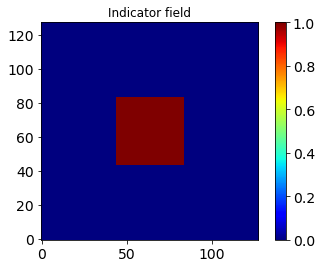

In [21]:
plt.imshow(alpha[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Indicator field')

Text(0.5, 1.0, 'Density field')

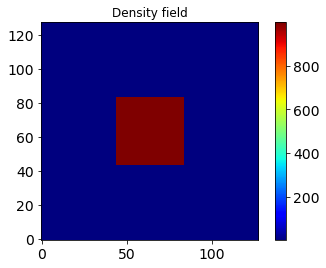

In [22]:
plt.imshow(rho[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Density field')

# AI-HFM Solver

In [37]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v] = boundary_condition_velocity(values_u,values_v,nx)
    values_p = boundary_condition_pressure(values_p,nx)
# Momentum equation 
    [k_x,k_y] = PG_turb_vector(values_u, values_v, eplsion_k)
    a_u = CNN3D_central_2nd_dif(values_u)/rho*dt - \
    values_u*CNN3D_central_2nd_xadv(values_u)*dt - \
    values_v*CNN3D_central_2nd_yadv(values_u)*dt  
    b_u = 0.5*a_u + values_u
    a_v = CNN3D_central_2nd_dif(values_v)/rho*dt - \
    values_u*CNN3D_central_2nd_xadv(values_v)*dt - \
    values_v*CNN3D_central_2nd_yadv(values_v)*dt  
    b_v = 0.5*a_v + values_v + g_z*dt

    [b_u,b_v] = boundary_condition_velocity(b_u,b_v,nx)
    [k_x,k_y] = PG_turb_vector(b_u, b_v, eplsion_k)
    
    c_u = CNN3D_central_2nd_dif(b_u)/rho*dt - \
    b_u*CNN3D_central_2nd_xadv(b_u)*dt - \
    b_v*CNN3D_central_2nd_yadv(b_u)*dt 
    values_u = values_u + c_u      
    c_v = CNN3D_central_2nd_dif(b_v)/rho*dt - \
    b_u*CNN3D_central_2nd_xadv(b_v)*dt - \
    b_v*CNN3D_central_2nd_yadv(b_v)*dt 
    values_v = values_v + c_v + g_z*dt
 
# Passive tracer scalar transport
    if LSCALAR == True:
        alpha = boundary_condition_indicator(alpha,nx)
        [k_alpha,alpha_x,alpha_y,scaling_x,scaling_y,k_u,k_d,Sx,Sy,k_x,k_y,k_xf,k_yf] = PG_turb_scalar(alpha, values_u, values_v, eplsion_k)
        a_t = CNN3D_central_2nd_dif(alpha)*dt - \
        CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
        CNN3D_central_2nd_yadv(values_v*alpha)*dt 
        alpha = alpha + a_t*0.5
        alpha = boundary_condition_indicator(alpha,nx)
        [k_alpha,alpha_x,alpha_y,scaling_x,scaling_y,k_u,k_d,Sx,Sy,k_x,k_y,k_xf,k_yf] = PG_turb_scalar(alpha, values_u, values_v, eplsion_k)
        a_t = CNN3D_central_2nd_dif(alpha)*dt - \
        CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
        CNN3D_central_2nd_yadv(values_v*alpha)*dt 
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
# IBM
    if LIBM == True:
        [values_u,values_v,values_w,alpha] = bluff_body(values_u,values_v,values_w,alpha,sigma)
# gradp            
    values_u = values_u - CNN3D_pu(values_p)/rho*dt
    values_v = values_v - CNN3D_pv(values_p)/rho*dt      
    [values_u,values_v] = boundary_condition_velocity(values_u,values_v,nx)
# possion equation (multi-grid) A*P = Su
#     temp_rho = CNN3D_Su(1/rho) + CNN3D_Sv(1/rho)
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v))*rho/dt
#     b = boundary_condition_source(b,nx)
    b = boundary_condition_indicator(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,1,1])
            r = CNN3D_A_128(values_p) - b  
#             r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
#             r_128 = CNN3D_res_256(r_256)
            rho_64 = CNN3D_res_128(rho) 
            rho_32 = CNN3D_res_64(rho_64) 
            rho_16 = CNN3D_res_32(rho_32) 
            rho_8 = CNN3D_res_16(rho_16) 
            rho_4 = CNN3D_res_8(rho_8) 
            rho_2 = CNN3D_res_4(rho_4) 
            rho_1 = CNN3D_res_2(rho_2)

            r_64 = CNN3D_res_128(r) 
            r_32 = CNN3D_res_64(r_64) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r_1 = CNN3D_res_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1/rho_1)/w4[0,1,1,0] + r_1/w4[0,1,1,0])
            w_2 = CNN3D_prol_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w4[0,1,1,0] + r_2/w4[0,1,1,0])
            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w4[0,1,1,0] + r_4/w4[0,1,1,0])
            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w4[0,1,1,0] + r_8/w4[0,1,1,0])
            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w4[0,1,1,0] + r_16/w4[0,1,1,0])
            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w4[0,1,1,0] + r_32/w4[0,1,1,0])
            w_64 = CNN3D_prol_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/w4[0,1,1,0] + r_64/w4[0,1,1,0])
            w_128 = CNN3D_prol_64(w_64) 
#             for Jacobi in range(j_itr):
#                 w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
#             w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_128
#             values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])         
            values_p = (values_p - CNN3D_A_128(values_p)/w4[0,1,1,0] + b/w4[0,1,1,0])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_pu(values_p)/rho*dt
    values_v = values_v - CNN3D_pv(values_p)/rho*dt        
    [values_u,values_v] = boundary_condition_velocity(values_u,values_v,nx)
    if LIBM == True:
        [values_u,values_v,values_w,alpha] = bluff_body(values_u,values_v,values_w,alpha,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_128), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_128)) > 0.2:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(alpha,n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

Time step: 1
Pressure error: 0.002949722 cty equation residual: 0.0017916857
time 20.191133975982666


Text(0.5, 1.0, 'Density field')

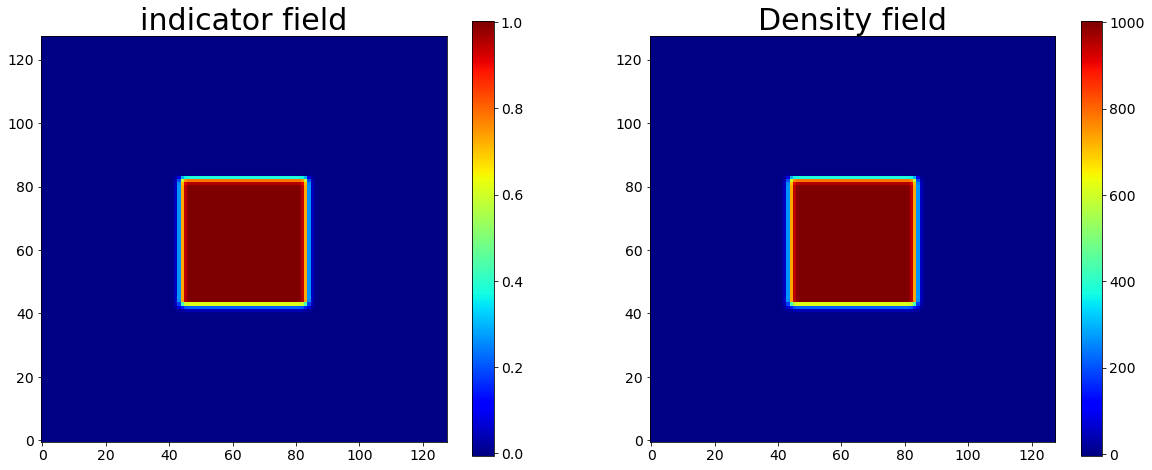

In [38]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(121)
plt.imshow(alpha[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('indicator field', fontsize=30)
ax1 = plt.subplot(122)
plt.imshow(rho[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Density field', fontsize=30)

Text(0.5, 1.0, 'C_yi')

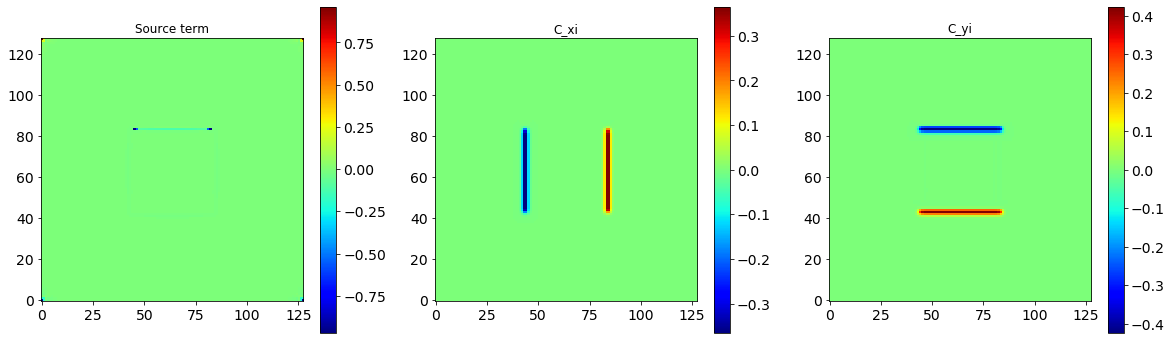

In [39]:
plt.figure(figsize=(20, 6))
ax1 = plt.subplot(131)
plt.imshow(b[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Source term')
ax1 = plt.subplot(132)
plt.imshow((alpha_x)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('C_xi')
ax1 = plt.subplot(133)
plt.imshow((alpha_y)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('C_yi')

Text(0.5, 1.0, 'vstar')

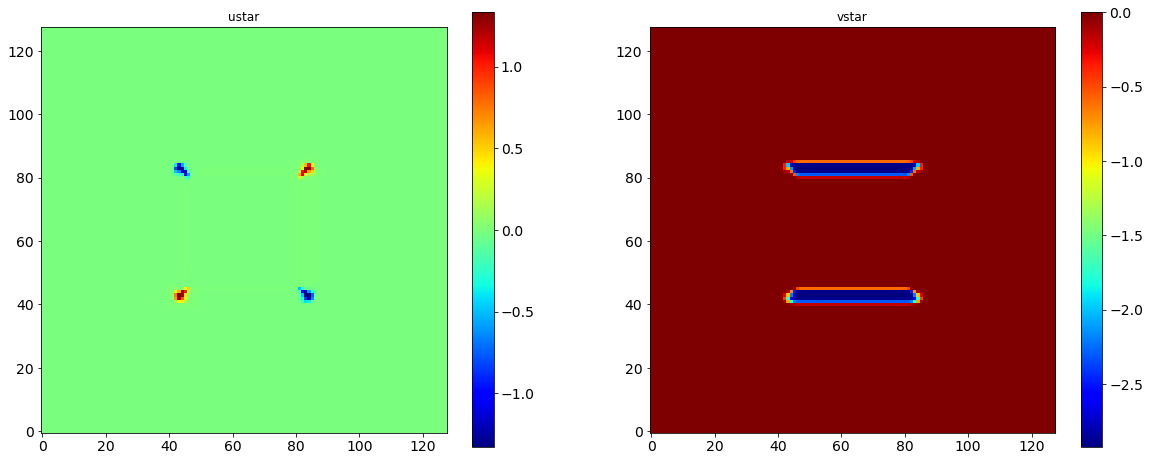

In [40]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(121)
plt.imshow((scaling_x)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('ustar')
ax1 = plt.subplot(122)
plt.imshow((scaling_y)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('vstar')

Text(0.5, 1.0, 'filter y')

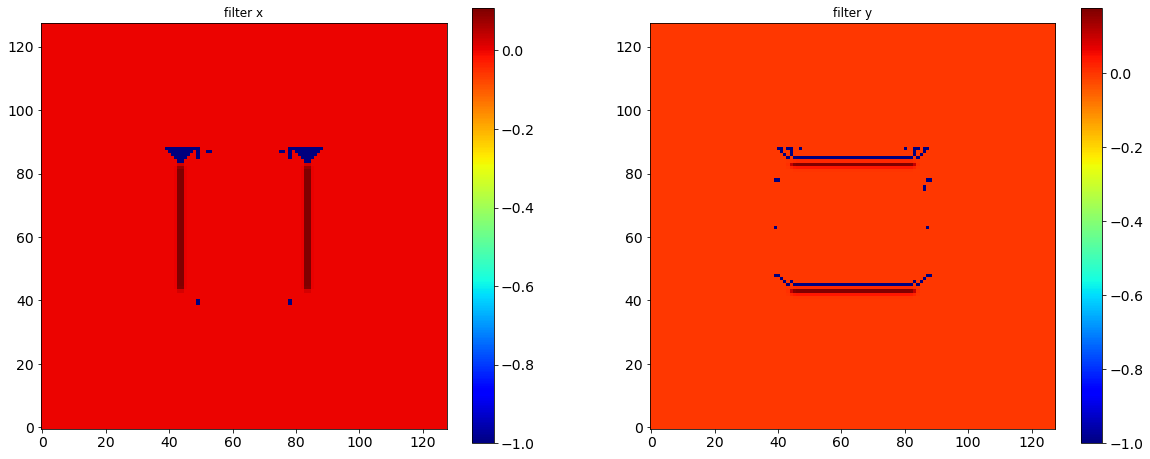

In [41]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(121)
plt.imshow((Sx)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('filter x')
ax1 = plt.subplot(122)
plt.imshow((Sy)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('filter y')

Text(0.5, 1.0, 'k-')

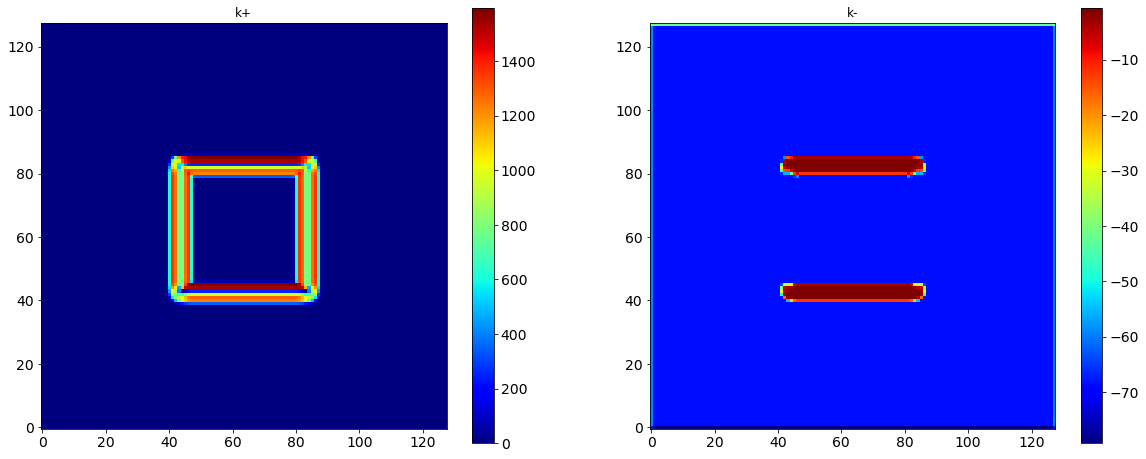

In [42]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(121)
plt.imshow((k_u)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('k+')
ax1 = plt.subplot(122)
plt.imshow((k_d)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('k-')

Text(0.5, 1.0, 'final ky')

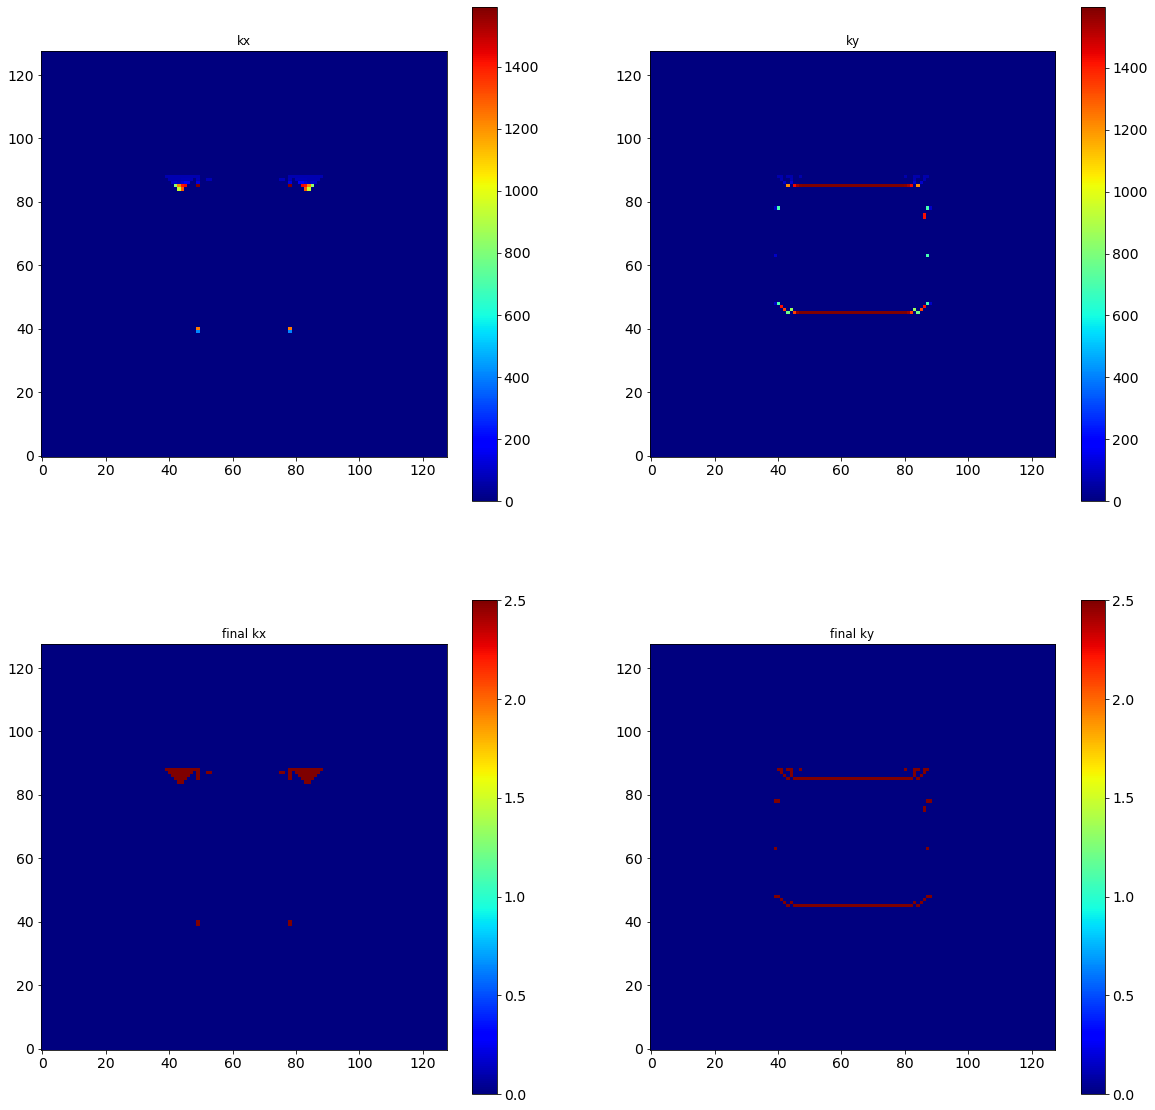

In [43]:
plt.figure(figsize=(20, 20))
ax1 = plt.subplot(221)
plt.imshow((k_x)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('kx')
ax1 = plt.subplot(222)
plt.imshow((k_y)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('ky')
ax1 = plt.subplot(223)
plt.imshow((k_xf)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('final kx')
ax1 = plt.subplot(224)
plt.imshow((k_yf)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('final ky')

Text(0.5, 1.0, 'v-component velocity')

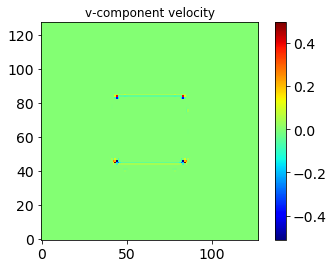

In [44]:
plt.imshow((k_alpha)[0,:,:,0], cmap='jet')
plt.colorbar()
# plt.axis('off')

plt.gca().invert_yaxis()
plt.title('v-component velocity')

Text(0.5, 1.0, 'v-component velocity')

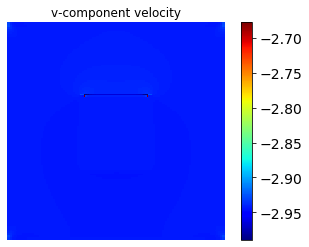

In [45]:
plt.imshow((values_v)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.axis('off')

plt.gca().invert_yaxis()
plt.title('v-component velocity')

Text(0.5, 1.0, 'u-component velocity')

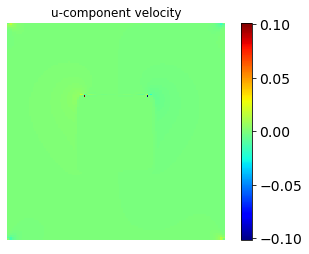

In [46]:
plt.imshow((values_u)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.axis('off')

plt.gca().invert_yaxis()

plt.title('u-component velocity')

Text(0.5, 1.0, 'Pressure at central xy plane')

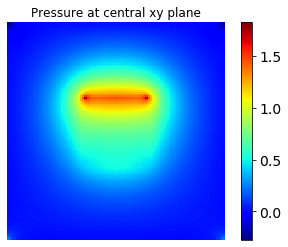

In [47]:
plt.imshow((-values_p)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.axis('off')
plt.gca().invert_yaxis()

plt.title('Pressure at central xy plane')

In [48]:
vel = (values_u**2+values_v**2)**0.5

Text(0.5, 1.0, 'u-component velocity')

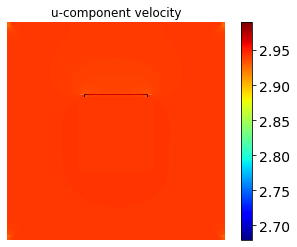

In [49]:
plt.imshow((vel)[0,:,:,0], cmap='jet')
plt.colorbar()
plt.axis('off')

plt.gca().invert_yaxis()

plt.title('u-component velocity')